# Project 1 Playground
Workbook for some data analysis experiments. Main goal is to explore how the self-perception of class compares to actual income. 

Cassandra Overney

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import itertools

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot

import utils
from utils import decorate

In [2]:
# Read in GSS data
def read_gss(dirname):
    """Reads GSS files from the given directory.
    
    dirname: string
    
    returns: DataFrame
    """
    dct = utils.read_stata_dict(dirname + '/GSS.dct')
    gss = dct.read_fixed_width(dirname + '/GSS.dat')
    return gss

gss = read_gss('Project1Data')
gss.head()

,year,rincome,region,srcbelt,partyid,polviews,satjob,class_,satfin,finrela,...,wrkstat,age,educ,sex,race,hompop,babies,preteen,teens,cohort
0,1972,0,3,3,2,0,3,3,3,3,...,1,23,16,2,1,1,0,0,0,1949
1,1972,0,3,3,1,0,0,3,2,4,...,5,70,10,1,1,2,0,0,0,1902
2,1972,0,3,3,3,0,2,2,1,3,...,2,48,12,2,1,4,0,1,1,1924
3,1972,0,3,3,1,0,1,3,3,3,...,1,27,17,2,1,2,0,0,0,1945
4,1972,0,3,3,0,0,0,2,1,4,...,7,61,12,2,1,2,0,0,0,1911


First, I will include stuff I did during HW2

In [3]:
gss.realinc.replace([0], np.nan, inplace=True)
gss['class_'].replace([5, 8, 9, 0], np.nan, inplace=True)

real_incomes = gss['realinc'] # total family income in constant $1000s (1986)
real_incomes_scaled = real_incomes/1000
classes = gss['class_'] # subjective class identification

Classes have four values:
- 1: lower class
- 2: working class
- 3: middle class
- 4: upper class

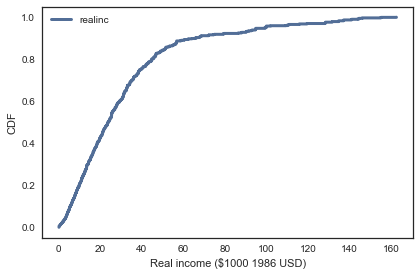

In [4]:
# Plot CDF of incomes
real_incomes_cdf = thinkstats2.Cdf(real_incomes_scaled, label='realinc')
thinkplot.Cdf(real_incomes_cdf)
decorate(xlabel='Real income ($1000 1986 USD)', ylabel='CDF')

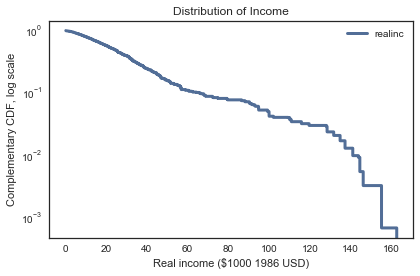

In [5]:
thinkplot.cdf(real_incomes_cdf, label='realinc', complement=True)

decorate(title='Distribution of Income', 
         xlabel='Real income ($1000 1986 USD)', 
         ylabel='Complementary CDF, log scale',
         yscale='log')

The distribution looks relatively straight. (I tried a Pareto distribution but it didn't look very straight, which raises some confusion. Maybe since this is scaled to 1986 dollars?) Doesn't look Pareto because cut off the tail. 

According to investopedia, middle class corresponds to incomes between \$40,500 and \$122,000, lower class corresponds to incomes below \$40,500, and upper class corresponds to incomes above \$122,000. GSS includes a working class which I estimate to be between \$14,000 and \$40,500, so I will break up the lower class into working and lower.     

I used an inflation calculator (https://www.usinflationcalculator.com/) to translate my 2017 income class values to 1986 amounts. Lower class is below \$6,259.79; working class is between \$6,259.79 and \$18,108.68; middle class is between \$18,108.68 and \$54,549.61; and upper class is above \$54,549.61.

In [6]:
calculated_classes = []
for income in real_incomes:
    if income > 54549.61:
        # upper class
        calculated_classes.append(4)
    elif income <= 54549.61 and income > 18108.68:
        # middle class
        calculated_classes.append(3)
    elif income <= 18108.68 and income > 6259.79:
        # working class
        calculated_classes.append(2)
    elif income <= 6259.79:
        # lower class
        calculated_classes.append(1)
calculated_classes = pd.Series(calculated_classes)
print(calculated_classes.head())

0    3
1    3
2    3
3    3
4    3
dtype: int64


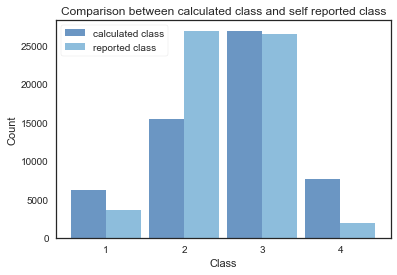

In [7]:
# Plot simple histograms for comparison
calculated_classes_hist = thinkstats2.Hist(calculated_classes, label='calculated class')
classes_hist = thinkstats2.Hist(classes, label='reported class')
width = 0.45
thinkplot.PrePlot(2)
thinkplot.Hist(calculated_classes_hist, align='right', width=width)
thinkplot.Hist(classes_hist, align='left', width=width)
thinkplot.Config(title='Comparison between calculated class and self reported class', xlabel='Class', ylabel='Count', xticks=[1, 2, 3, 4])

It seems like people may think they are in a lower class than they actually are with most people considering themselves as part of the working or middle classes. The difference is especially apparent in the working class (more people think they are in that class than they actually are). Also, more people qualify as upper class than they think. This observation is beautifully summarized by Stephen Rose's quote that “because people tend to live in communities with similar incomes, they view themselves as being near the middle because their neighbors’ circumstances are similar to their own even if their incomes are significantly below or above the US median.”

In [8]:
# Find cohen effect size
cohen = thinkstats2.CohenEffectSize(classes, calculated_classes)
cohen

-0.2521712437405217

The Cohen effect size is relatively large, indicating that reported classes tend to be lower than actual classes.

I did some more research on what constitutes different income classes and found the following information:
- Middle class means earning between 2/3 and double the median household income **after incomes have been adjusted for household size**.
- Lower income group is divided into lowest-income households and lower-middle income households (working class). Lower class means earning less than half of median. Working class means earning between 1/2 and 2/3 median. 
- Upper class means earning more than double the median
- Incomes can be adjusted for household size and scaled to reflect houseful size of three. Placed in incomes tiers based on household income in calendar year previous to survey year. 
- Adjusted income = Household income / (Household size)^N, N=0.5 since standard
- Three-person household income = Adjusted household income * [(3)^0.5]
- Median household income in US changed over time (beyond inflation), so mere inflation adjustment doesn't work. 
- Good variable for self-perception on class is **subjective class**.
- Income data adjusted for inflation using Consumer Price Index Research Series (CPI-U-RS), which is important for measures of absolute progress over time.
- Inflation-adjusted estimate = year estimate * (ref CPI-U-RS / year CPI-U-RS)

My plan is to use the realinc data and convert to constant 2015 dollars since that probably makes more sense. I got median incomes in 2015 dollars. From there I will adjust the incomes based on the household size. 

**Need to find data for median household size for median household incomes** After looking at the average median household sizes, I am fairly confident that the median household size from 1971 to 2015 is 3, so I don't need to adjust the medians for household size. 

After that, I will use newly adjusted median incomes to calculate income classes for each respondent.

In [9]:
# Read in median income data from Excel file from specific column and rows
median_income_file = 'Project1Data/median_income.xls'
median_income_df = pd.read_excel(median_income_file, index_col=None, na_values=['NA'], usecols="M").iloc[1:47]
# Generate list of years as strings
years = list(range(2015, 1970, -1))
years.insert(2, '2013_2') # Add another 2013 to account for two 2013 median incomes
print(years)
median_income_df.index = years # Set the index to years
median_income_df = median_income_df.drop(median_income_df.index[[2]]) # drop the first 2013 (has higher SE)
median_income_df

[2015, 2014, '2013_2', 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983, 1982, 1981, 1980, 1979, 1978, 1977, 1976, 1975, 1974, 1973, 1972, 1971]


,Median income (dollars)
2015,56516
2014,53718
2013,52850.1
2012,52665.9
2011,52750.6
2010,53568.2
2009,54988.4
2008,55376.2
2007,57423.3
2006,56663


In [10]:
# Convert realinc data to constant 2015 dollars
cpi_ratio = 348.9/168.6
real_incomes_2015 = real_incomes*cpi_ratio

In [11]:
# Adjust income for household size (to 3 person household)
gss['hompop'].replace([99], np.nan, inplace=True)
household_sizes = gss['hompop']
adjusted_real_incomes_2015 = (real_incomes_2015/(household_sizes**0.5))*(3**0.5)

In [12]:
# Calculate income classes
income_years = gss['year'] - 1 # minus 1 since report last year's income
income_classes = []
for index, resp_yr in enumerate(income_years):
    temp_median = median_income_df.loc[resp_yr]['Median income (dollars)']
    temp_income = adjusted_real_incomes_2015[index]
    temp_prop = temp_income/temp_median
    if temp_prop > 2:
        # upper
        income_classes.append(4)
    elif temp_prop <= 2 and temp_prop >= (2/3):
        # middle 
        income_classes.append(3)
    elif temp_prop >= (1/2) and temp_prop < (2/3):
        # working
        income_classes.append(2)
    elif temp_prop < (1/2):
        # lower
        income_classes.append(1)
    else:
        # nan
        income_classes.append(np.nan)

income_classes = pd.Series(income_classes)
print(income_classes.head())

0    3.0
1    3.0
2    3.0
3    3.0
4    4.0
dtype: float64


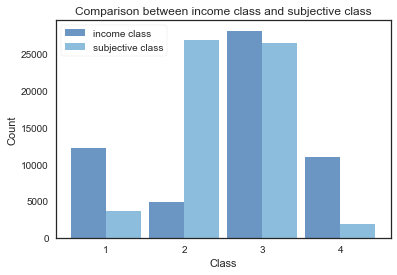

In [13]:
# Plot simple histograms for comparison
income_classes_hist = thinkstats2.Hist(income_classes, label='income class')
classes_hist = thinkstats2.Hist(classes, label='subjective class')
width = 0.45
thinkplot.PrePlot(2)
thinkplot.Hist(income_classes_hist, align='right', width=width)
thinkplot.Hist(classes_hist, align='left', width=width)
thinkplot.Config(title='Comparison between income class and subjective class', xlabel='Class', ylabel='Count', xticks=[1, 2, 3, 4])

Observations from histogram above:
- More lower income class than lower subjective class
- More respondents view themselves as being in the working or middle classes. 
- Most respondents are in the middle class. 
- More upper income class than upper subjective class.
- The most significant difference between income class and subjective class is seen in the working class. 

In [14]:
# Find cohen effect size
cohen2 = thinkstats2.CohenEffectSize(classes, income_classes)
cohen2

-0.2599501109479166

Pairwise gives Confusion matrix (guesses on one axis and reality on another axis) 4*4, numbers, colored by density 

In [15]:
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt

In [16]:
print(len(income_classes), len(classes))
class_true = classes
class_pred = income_classes
confusion_matrix = ConfusionMatrix(class_true, class_pred)
print("Confusion matrix:\n%s" % confusion_matrix)

# Print a bunch of confusion matrix stats (with p-values)
# confusion_matrix.print_stats()

62466 62466
Confusion matrix:
Predicted    1.0   2.0    3.0    4.0  __all__
Actual                                       
1.0         2190   395    629     42     3256
2.0         5696  2849  13837   2247    24629
3.0         3326  1360  11869   7090    23645
4.0          261    64    334    991     1650
__all__    11473  4668  26669  10370    53180


In [17]:
# Convert confusion matrix into data frame and then numpy arrays
cm_df = confusion_matrix.to_dataframe()
cm = cm_df.values

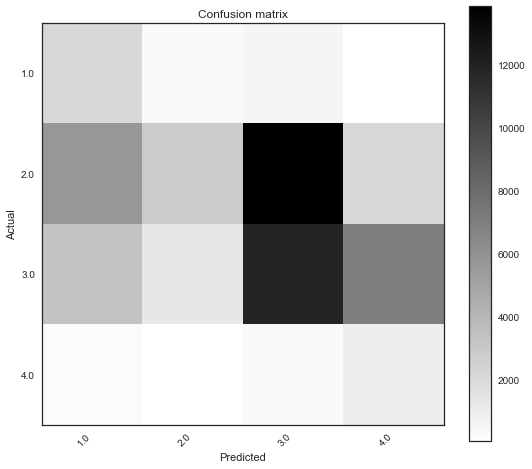

In [18]:
confusion_matrix.plot()
plt.show()

Using a confusion matrix plotting function I found [here](https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels), I will beautify my confusion matrix. 

In [19]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True, y_label='True plot', x_label='Predicted label'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        #plt.xticks(tick_marks, target_names, rotation=45)
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        #cm2 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm2 = cm.astype('float') / cm.sum()

    thresh = cm.max() / 2

    #thresh = cm2.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:,}\n{:0.1f}%".format(cm[i, j], cm2[i, j]*100),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel(y_label, labelpad=10)
    #plt.xlabel(x_label+'\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), labelpad=10)
    plt.xlabel(x_label, labelpad=10)
    plt.colorbar()
    plt.show()

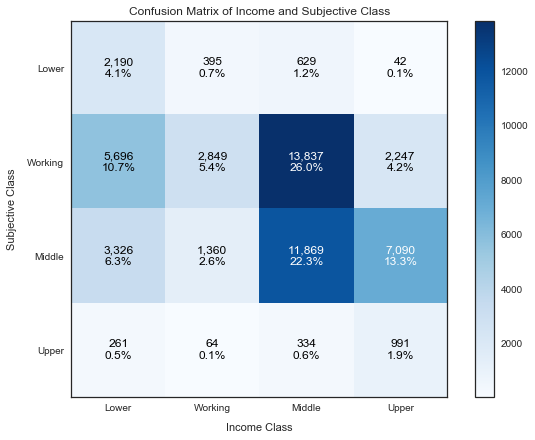

In [20]:
# First need to generate sklearn confusion matrix
plot_confusion_matrix(cm,['Lower', 'Working', 'Middle', 'Upper'],title='Confusion Matrix of Income and Subjective Class',cmap=None,normalize=True, y_label='Subjective Class', x_label='Income Class')

**Question**: What is the best way to do the frequencies? 

I gleaned the following observations from the above confusion matrix:
- Most of the subjective classes are working or middle class.
- Very few respondents proclaim themselves to be upper class even if their income classes are. 
- Respondents from the lower income class are more likely to consider themselves working class than lower or middle class.
- There are actually surprisingly few people in the working income class. Those who are mainly characterize themselves as working class.
- Most respondents lie in the middle income class and they mainly characterize themselves as either working or middle class (with working class being more common).
- Respondents from the upper income class are more likely to consider themselves middle and then working class compared to upper class.

Now, I will make segmented bar charts for subject class, stfin, and finrela. The different bars will correspond to different income ranges. 

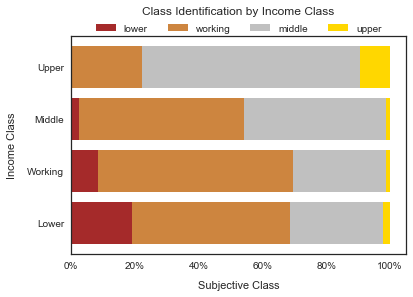

In [21]:
# For subjective class
x_values = ['Lower', 'Working', 'Middle', 'Upper']
x_pos = [i for i, _ in enumerate(x_values)]

total = cm[0,:]+cm[1,:]+cm[2,:]+cm[3,:]

prop_lower = np.true_divide(cm[0,:], total) * 100
prop_working = np.true_divide(cm[1,:], total) * 100
prop_middle = np.true_divide(cm[2,:], total) * 100
prop_upper = np.true_divide(cm[3,:], total) * 100

plt.barh(x_pos, prop_upper, height=0.8, label='upper', color='gold', 
        left=prop_middle+prop_working+prop_lower)
plt.barh(x_pos, prop_middle, height=0.8, label='middle', color='silver', 
        left=prop_working+prop_lower)
plt.barh(x_pos, prop_working, height=0.8, label='working', color='#CD853F', 
        left=prop_lower)
plt.barh(x_pos, prop_lower, height=0.8, label='lower', color='brown')

plt.yticks(x_pos, x_values)
locs, labels = plt.xticks()
plt.xticks(locs[:-1], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.ylabel("Income Class", labelpad=10)
plt.xlabel("Subjective Class", labelpad=10)
plt.title("Class Identification by Income Class", pad=22)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper center", bbox_to_anchor=(0.5, 1.10),
          ncol=4)

plt.show()

I will redo graph above to have y-axis be different income ranges. Here is the key for income ranges:
- 1: less than \$20,000
- 2: \$20,000-\$29,999
- 3: \$30,000-\$49,999
- 4: \$50,000-\$74,999
- 5: \$75,000-\$99,999
- 6: above \$100,000

In [22]:
# First need to calculate income ranges
income_ranges = []
for index, income in enumerate(adjusted_real_incomes_2015):
    if income >= 100000:
        income_ranges.append(6)
    elif income >= 75000:
        income_ranges.append(5)
    elif income >= 50000:
        income_ranges.append(4)
    elif income >= 30000:
        income_ranges.append(3)
    elif income >= 20000:
        income_ranges.append(2)
    elif income < 20000:
        income_ranges.append(1)
    else:
        income_ranges.append(np.nan)

income_ranges = pd.Series(income_ranges)
print(income_ranges.head())

0    4.0
1    4.0
2    3.0
3    5.0
4    6.0
dtype: float64


C:\ProgramData\Miniconda3\lib\site-packages\pandas_ml\confusion_matrix\abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


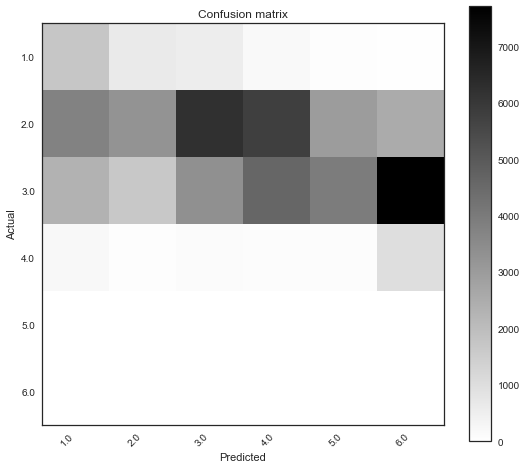

In [23]:
# Confusion matrix with income_ranges and subjective classes
confusion_matrix1 = ConfusionMatrix(classes, income_ranges)
cm_df1 = confusion_matrix1.to_dataframe()
cm1 = cm_df1.values
confusion_matrix1.plot()
plt.show()

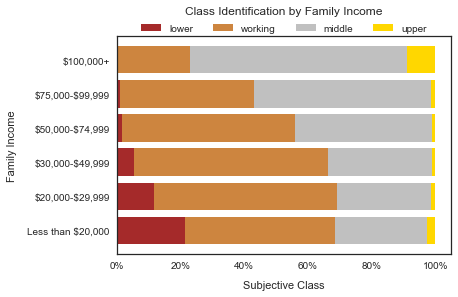

In [24]:
# Plot bar chart
x_values = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
x_pos = [i for i, _ in enumerate(x_values)]

total = cm1[0,:]+cm1[1,:]+cm1[2,:]+cm1[3,:]

prop_lower = np.true_divide(cm1[0,:], total) * 100
prop_working = np.true_divide(cm1[1,:], total) * 100
prop_middle = np.true_divide(cm1[2,:], total) * 100
prop_upper = np.true_divide(cm1[3,:], total) * 100

plt.barh(x_pos, prop_upper, height=0.8, label='upper', color='gold', 
        left=prop_middle+prop_working+prop_lower)
plt.barh(x_pos, prop_middle, height=0.8, label='middle', color='silver', 
        left=prop_working+prop_lower)
plt.barh(x_pos, prop_working, height=0.8, label='working', color='#CD853F', 
        left=prop_lower)
plt.barh(x_pos, prop_lower, height=0.8, label='lower', color='brown')

plt.yticks(x_pos, x_values)
locs, labels = plt.xticks()
plt.xticks(locs[:-1], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.ylabel("Family Income", labelpad=10)
plt.xlabel("Subjective Class", labelpad=10)
plt.title("Class Identification by Family Income", pad=22)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper center", bbox_to_anchor=(0.5, 1.10),
          ncol=4)

plt.show()

Now I will try to duplicate the figure in the paper, which means getting rid of respondents younger than 25 and only using years 2000-2004. Also, I only want the respondents that are employed.

In [218]:
sub_gss = gss[(gss['year'] >= 2000) & (gss['year'] <= 2004) & (gss['age'] >= 25) 
              & (gss['wrkstat'] <= 3)]
sub_real_incomes = sub_gss['realinc']
sub_classes = sub_gss['class_']
cpi_ratio2 = 277.5/168.6
sub_real_incomes_2015 = sub_real_incomes*cpi_ratio2
print(sub_real_incomes_2015.head())
sub_household_sizes = sub_gss['hompop']
sub_adjusted_real_incomes_2015 = (sub_real_incomes_2015/(sub_household_sizes**0.5))*(3**0.5)

38116             NaN
38117     9850.756228
38119    49253.781139
38120    41043.994662
38121             NaN
Name: realinc, dtype: float64


In [219]:
# Calculate income ranges
sub_income_ranges = []
for index, income in enumerate(sub_adjusted_real_incomes_2015):
    if income >= 100000:
        sub_income_ranges.append(6)
    elif income >= 75000:
        sub_income_ranges.append(5)
    elif income >= 50000:
        sub_income_ranges.append(4)
    elif income >= 30000:
        sub_income_ranges.append(3)
    elif income >= 20000:
        sub_income_ranges.append(2)
    elif income < 20000:
        sub_income_ranges.append(1)
    else:
        sub_income_ranges.append(np.nan)

sub_income_ranges = pd.Series(sub_income_ranges, index=sub_classes.index)
print(sub_income_ranges.head())

38116    NaN
38117    1.0
38119    5.0
38120    4.0
38121    NaN
dtype: float64


C:\ProgramData\Miniconda3\lib\site-packages\pandas_ml\confusion_matrix\abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


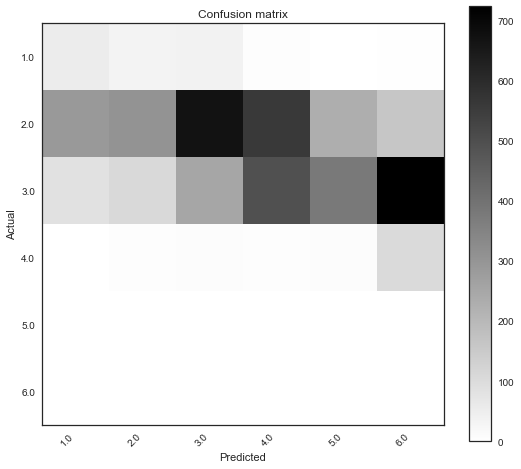

In [220]:
# Confusion matrix with sub_income_ranges and sub_subjective classes
sub_confusion_matrix1 = ConfusionMatrix(sub_classes, sub_income_ranges)
sub_cm_df1 = sub_confusion_matrix1.to_dataframe()
sub_cm1 = sub_cm_df1.values
sub_confusion_matrix1.plot()
plt.show()

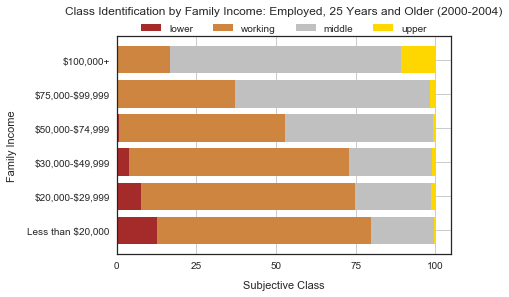

In [221]:
# Plot bar chart
x_values = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
x_pos = [i for i, _ in enumerate(x_values)]

total = sub_cm1[0,:]+sub_cm1[1,:]+sub_cm1[2,:]+sub_cm1[3,:]

prop_lower = np.true_divide(sub_cm1[0,:], total) * 100
prop_working = np.true_divide(sub_cm1[1,:], total) * 100
prop_middle = np.true_divide(sub_cm1[2,:], total) * 100
prop_upper = np.true_divide(sub_cm1[3,:], total) * 100

plt.barh(x_pos, prop_upper, height=0.8, label='upper', color='gold', 
        left=prop_middle+prop_working+prop_lower)
plt.barh(x_pos, prop_middle, height=0.8, label='middle', color='silver', 
        left=prop_working+prop_lower)
plt.barh(x_pos, prop_working, height=0.8, label='working', color='#CD853F', 
        left=prop_lower)
plt.barh(x_pos, prop_lower, height=0.8, label='lower', color='brown')

plt.yticks(x_pos, x_values)
# locs, labels = plt.xticks()
# plt.xticks(locs[:-1], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.xticks([0, 25, 50, 75, 100])
plt.grid()
plt.ylabel("Family Income", labelpad=10)
plt.xlabel("Subjective Class", labelpad=10)
plt.title("Class Identification by Family Income: Employed, 25 Years and Older (2000-2004)", pad=22)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper center", bbox_to_anchor=(0.5, 1.10),
          ncol=4)

plt.show()

My version of this figure is quite different from the one in the paper. 

QUESTION: **Could this be due to household size adjustment?**

GOAL = replicate this figure!!

Almost identical figure below:

In [214]:
sub_gss2 = gss[(gss['year'] >= 2000) & (gss['year'] <= 2004) & (gss['age'] >= 25) 
              & (gss['wrkstat'] <= 3)]
sub_real_incomes2 = sub_gss2['realinc']
sub_classes2 = sub_gss2['class_']
cpi_ratio2 = 277.5/168.6
sub_real_incomes_20152 = sub_real_incomes2*cpi_ratio2
print(sub_real_incomes_20152.head())

38116             NaN
38117     9850.756228
38119    49253.781139
38120    41043.994662
38121             NaN
Name: realinc, dtype: float64


In [215]:
# Calculate income ranges
sub_income_ranges2 = []
for index, income in enumerate(sub_real_incomes_20152):
    if income >= 100000:
        sub_income_ranges2.append(6)
    elif income >= 75000:
        sub_income_ranges2.append(5)
    elif income >= 50000:
        sub_income_ranges2.append(4)
    elif income >= 30000:
        sub_income_ranges2.append(3)
    elif income >= 20000:
        sub_income_ranges2.append(2)
    elif income < 20000:
        sub_income_ranges2.append(1)
    else:
        sub_income_ranges2.append(np.nan)

sub_income_ranges2 = pd.Series(sub_income_ranges2, index=sub_classes2.index)
print(sub_income_ranges2.head())

38116    NaN
38117    1.0
38119    3.0
38120    3.0
38121    NaN
dtype: float64


C:\ProgramData\Miniconda3\lib\site-packages\pandas_ml\confusion_matrix\abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


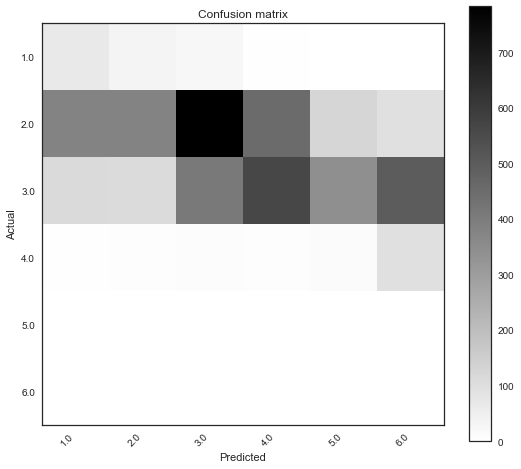

In [216]:
# Confusion matrix with sub_income_ranges and sub_subjective classes
sub_confusion_matrix2 = ConfusionMatrix(sub_classes2, sub_income_ranges2)
sub_cm_df2 = sub_confusion_matrix2.to_dataframe()
sub_cm2 = sub_cm_df2.values
sub_confusion_matrix2.plot()
plt.show()

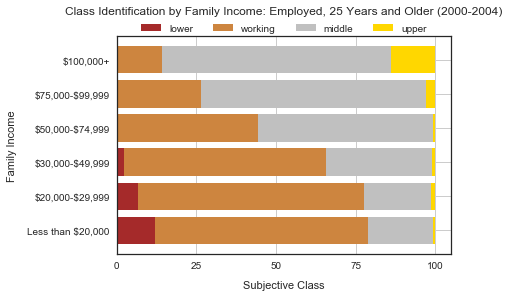

In [217]:
# Plot bar chart
x_values = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
x_pos = [i for i, _ in enumerate(x_values)]

total = sub_cm2[0,:]+sub_cm2[1,:]+sub_cm2[2,:]+sub_cm2[3,:]

prop_lower = np.true_divide(sub_cm2[0,:], total) * 100
prop_working = np.true_divide(sub_cm2[1,:], total) * 100
prop_middle = np.true_divide(sub_cm2[2,:], total) * 100
prop_upper = np.true_divide(sub_cm2[3,:], total) * 100

plt.barh(x_pos, prop_upper, height=0.8, label='upper', color='gold', 
        left=prop_middle+prop_working+prop_lower)
plt.barh(x_pos, prop_middle, height=0.8, label='middle', color='silver', 
        left=prop_working+prop_lower)
plt.barh(x_pos, prop_working, height=0.8, label='working', color='#CD853F', 
        left=prop_lower)
plt.barh(x_pos, prop_lower, height=0.8, label='lower', color='brown')

plt.yticks(x_pos, x_values)
# locs, labels = plt.xticks()
# plt.xticks(locs[:-1], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.xticks([0, 25, 50, 75, 100])
plt.grid()
plt.ylabel("Family Income", labelpad=10)
plt.xlabel("Subjective Class", labelpad=10)
plt.title("Class Identification by Family Income: Employed, 25 Years and Older (2000-2004)", pad=22)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper center", bbox_to_anchor=(0.5, 1.10),
          ncol=4)

plt.show()

For the finrela variable, the question is "Compared with American families in general, would you say your family income is far below average, below average, average, above average, or far above average?" The possible values are
- 1: far below average
- 2: below average
- 3: average
- 4: above average
- 5: far above average

In [29]:
# For finrela, get data first
gss['finrela'].replace([0, 8, 9], np.nan, inplace=True)
finrelas = gss['finrela']

C:\ProgramData\Miniconda3\lib\site-packages\pandas_ml\confusion_matrix\abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


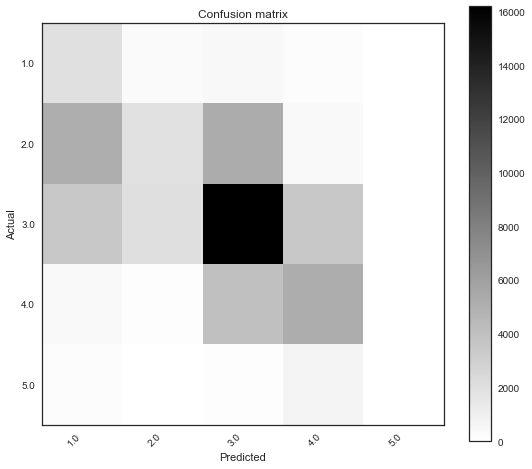

In [30]:
# Generate confusion matrix and conert into numpy array
class_pred = income_classes
confusion_matrix2 = ConfusionMatrix(finrelas, class_pred)
cm_df2 = confusion_matrix2.to_dataframe()
cm2 = cm_df2.values
confusion_matrix2.plot()
plt.show()

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


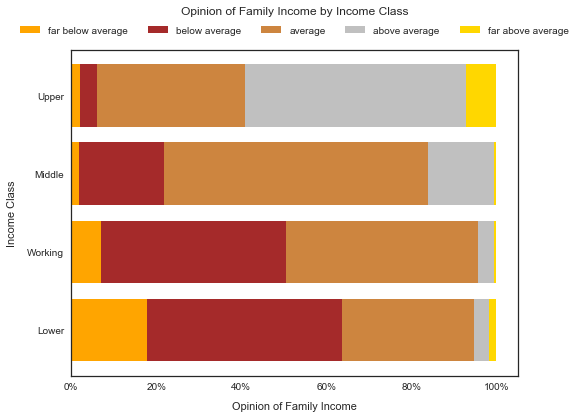

In [31]:
plt.figure(figsize=(8, 6))
x_values = ['Lower', 'Working', 'Middle', 'Upper']
x_pos = [i for i, _ in enumerate(x_values)]

total = cm2[0,:]+cm2[1,:]+cm2[2,:]+cm2[3,:]+cm2[4,:]

prop_farbelow = (np.true_divide(cm2[0,:], total) * 100)[:-1]
prop_below = (np.true_divide(cm2[1,:], total) * 100)[:-1]
prop_average = (np.true_divide(cm2[2,:], total) * 100)[:-1]
prop_above = (np.true_divide(cm2[3,:], total) * 100)[:-1]
prop_farabove = (np.true_divide(cm2[4,:], total) * 100)[:-1]

plt.barh(x_pos, prop_farabove, height=0.8, label='far above average', color='gold', 
        left=prop_above+prop_average+prop_below+prop_farbelow)
plt.barh(x_pos, prop_above, height=0.8, label='above average', color='silver', 
        left=prop_average+prop_below+prop_farbelow)
plt.barh(x_pos, prop_average, height=0.8, label='average', color='#CD853F', 
        left=prop_below+prop_farbelow)
plt.barh(x_pos, prop_below, height=0.8, label='below average', color='brown', 
        left=prop_farbelow)
plt.barh(x_pos, prop_farbelow, height=0.8, label='far below average', color='orange')

plt.yticks(x_pos, x_values)
locs, labels = plt.xticks()
plt.xticks(locs[:-1], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.ylabel("Income Class", labelpad=10)
plt.xlabel("Opinion of Family Income", labelpad=10)
plt.title("Opinion of Family Income by Income Class", pad=35)
handles, labels = plt.gca().get_legend_handles_labels()
order = [4, 3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper center", bbox_to_anchor=(0.5, 1.10),
          ncol=5)
plt.show()

For the satfin variable, the question is "We are interested in how people are getting along financially these days. So far as you and your family are concerned, would you say that you are pretty well satisfied with your present financial situation, more or less satisfied, or not satisfied at all?" The possible values are:
- 1: satisfied
- 2: more or less
- 3: not at all sat

In [32]:
# Get data first
gss['satfin'].replace([0, 8, 9], np.nan, inplace=True)
satfins = gss['satfin']

C:\ProgramData\Miniconda3\lib\site-packages\pandas_ml\confusion_matrix\abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


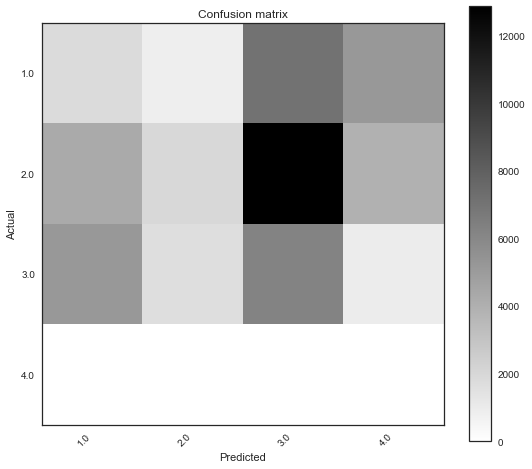

In [33]:
# Generate confusion matrix and conert into numpy array
class_pred = income_classes
confusion_matrix3 = ConfusionMatrix(satfins, class_pred)
cm_df3 = confusion_matrix3.to_dataframe()
cm3 = cm_df3.values
confusion_matrix3.plot()
plt.show()

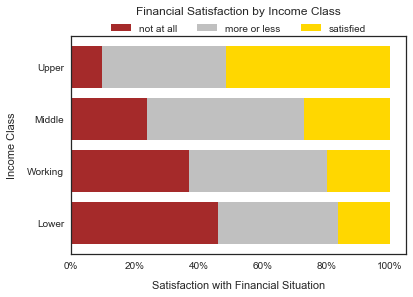

In [34]:
x_values = ['Lower', 'Working', 'Middle', 'Upper']
x_pos = [i for i, _ in enumerate(x_values)]

total = cm3[0,:]+cm3[1,:]+cm3[2,:]

prop_yes = np.true_divide(cm3[0,:], total) * 100
prop_okay = np.true_divide(cm3[1,:], total) * 100
prop_no = np.true_divide(cm3[2,:], total) * 100

plt.barh(x_pos, prop_yes, height=0.8, label='satisfied', color='gold', 
        left=prop_okay+prop_no)
plt.barh(x_pos, prop_okay, height=0.8, label='more or less', color='silver', 
        left=prop_no)
plt.barh(x_pos, prop_no, height=0.8, label='not at all', color='brown')

plt.yticks(x_pos, x_values)
locs, labels = plt.xticks()
plt.xticks(locs[:-1], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.ylabel("Income Class", labelpad=10)
plt.xlabel("Satisfaction with Financial Situation", labelpad=10)
plt.title("Financial Satisfaction by Income Class", pad=22)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper center", bbox_to_anchor=(0.5, 1.10),
          ncol=3)

plt.show()

What is the story? What was a number in the past and what was a number now? Find group of people in 2000 and comparable group of people now, what fraction say they are upper class. 

Notes from the paper that took me forever to finally read:
- people under 25 years of age are excluded because of absence bias (people in college)
- the subjective class question for GSS doesn't seem to be asked based on the answer to another question
- compared subjective class with subjective income with an **ordered logistic regression model**
- references this [resource](http://sda.berkeley.edu/archive.htm)
- found that upper and lower class identification arose in class positions that were clearly above or below that middle class/ working class border.
- class considered as independent variable and others variables are dependent variables?!
- does not mention adjustment for household size at all! 

I will look at the subjective class distribution vs income range for each srcbelt value to see if they differ. For now, I will not consider employment or age.

In [222]:
gss['income_ranges'] = income_ranges
grouped_srcbelt = gss.groupby('srcbelt')

In [226]:
confusion_matrices = []
for name, group in grouped_srcbelt:
    temp_classes = group['class_']
    temp_income_ranges = group['income_ranges']
    # Should turn this into a function
    # Confusion matrix with income_ranges and subjective classes
    temp_confusion_matrix = ConfusionMatrix(temp_classes, temp_income_ranges)
    temp_cm_df = temp_confusion_matrix.to_dataframe()
    temp_cm = temp_cm_df.values
    confusion_matrices.append(temp_cm)

C:\ProgramData\Miniconda3\lib\site-packages\pandas_ml\confusion_matrix\abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


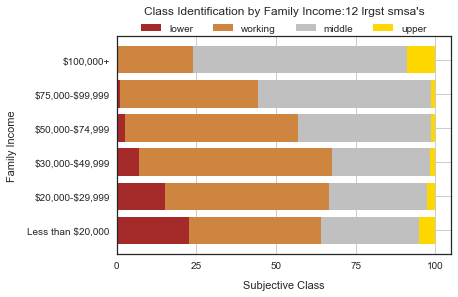

In [232]:
# 12 lrgst smsa's
lrgst_cm = confusion_matrices[0]
x_values = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
x_pos = [i for i, _ in enumerate(x_values)]

total = lrgst_cm[0,:]+lrgst_cm[1,:]+lrgst_cm[2,:]+lrgst_cm[3,:]

prop_lower = np.true_divide(lrgst_cm[0,:], total) * 100
prop_working = np.true_divide(lrgst_cm[1,:], total) * 100
prop_middle = np.true_divide(lrgst_cm[2,:], total) * 100
prop_upper = np.true_divide(lrgst_cm[3,:], total) * 100

plt.barh(x_pos, prop_upper, height=0.8, label='upper', color='gold', 
        left=prop_middle+prop_working+prop_lower)
plt.barh(x_pos, prop_middle, height=0.8, label='middle', color='silver', 
        left=prop_working+prop_lower)
plt.barh(x_pos, prop_working, height=0.8, label='working', color='#CD853F', 
        left=prop_lower)
plt.barh(x_pos, prop_lower, height=0.8, label='lower', color='brown')

plt.yticks(x_pos, x_values)
plt.xticks([0, 25, 50, 75, 100])
plt.grid()
plt.ylabel("Family Income", labelpad=10)
plt.xlabel("Subjective Class", labelpad=10)
plt.title("Class Identification by Family Income:12 lrgst smsa's", pad=22)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper center", bbox_to_anchor=(0.5, 1.10),
          ncol=4)

plt.show()

[45.0174216  58.09080326 58.36154367 54.30416069 42.32804233 22.74709302]


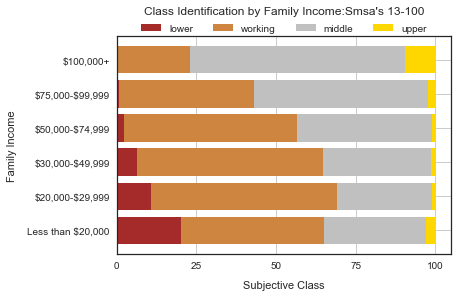

In [239]:
# Smsa's 13-100
med_cm = confusion_matrices[1]
x_values = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
x_pos = [i for i, _ in enumerate(x_values)]

total = med_cm[0,:]+med_cm[1,:]+med_cm[2,:]+med_cm[3,:]

prop_lower = np.true_divide(med_cm[0,:], total) * 100
prop_working = np.true_divide(med_cm[1,:], total) * 100
prop_middle = np.true_divide(med_cm[2,:], total) * 100
prop_upper = np.true_divide(med_cm[3,:], total) * 100

print(prop_working)

plt.barh(x_pos, prop_upper, height=0.8, label='upper', color='gold', 
        left=prop_middle+prop_working+prop_lower)
plt.barh(x_pos, prop_middle, height=0.8, label='middle', color='silver', 
        left=prop_working+prop_lower)
plt.barh(x_pos, prop_working, height=0.8, label='working', color='#CD853F', 
        left=prop_lower)
plt.barh(x_pos, prop_lower, height=0.8, label='lower', color='brown')

plt.yticks(x_pos, x_values)
plt.xticks([0, 25, 50, 75, 100])
plt.grid()
plt.ylabel("Family Income", labelpad=10)
plt.xlabel("Subjective Class", labelpad=10)
plt.title("Class Identification by Family Income:Smsa's 13-100", pad=22)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper center", bbox_to_anchor=(0.5, 1.10),
          ncol=4)

plt.show()

[46.68049793 56.06060606 60.41909197 51.90641248 38.2131324  17.49419954]


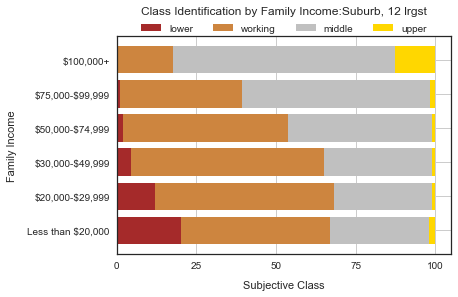

In [238]:
# Suburb, 12 lrgst
lrg_sub_cm = confusion_matrices[2]
x_values = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
x_pos = [i for i, _ in enumerate(x_values)]

total = lrg_sub_cm[0,:]+lrg_sub_cm[1,:]+lrg_sub_cm[2,:]+lrg_sub_cm[3,:]

prop_lower = np.true_divide(lrg_sub_cm[0,:], total) * 100
prop_working = np.true_divide(lrg_sub_cm[1,:], total) * 100
prop_middle = np.true_divide(lrg_sub_cm[2,:], total) * 100
prop_upper = np.true_divide(lrg_sub_cm[3,:], total) * 100

print(prop_working)

plt.barh(x_pos, prop_upper, height=0.8, label='upper', color='gold', 
        left=prop_middle+prop_working+prop_lower)
plt.barh(x_pos, prop_middle, height=0.8, label='middle', color='silver', 
        left=prop_working+prop_lower)
plt.barh(x_pos, prop_working, height=0.8, label='working', color='#CD853F', 
        left=prop_lower)
plt.barh(x_pos, prop_lower, height=0.8, label='lower', color='brown')

plt.yticks(x_pos, x_values)
plt.xticks([0, 25, 50, 75, 100])
plt.grid()
plt.ylabel("Family Income", labelpad=10)
plt.xlabel("Subjective Class", labelpad=10)
plt.title("Class Identification by Family Income:Suburb, 12 lrgst", pad=22)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper center", bbox_to_anchor=(0.5, 1.10),
          ncol=4)

plt.show()

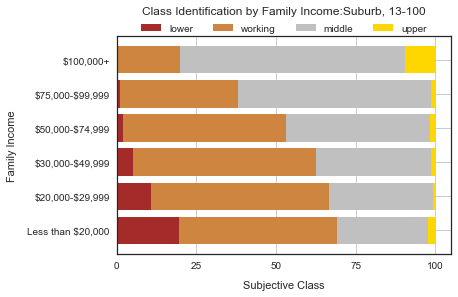

In [235]:
# Suburb, 13-100
med_sub_cm = confusion_matrices[3]
x_values = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
x_pos = [i for i, _ in enumerate(x_values)]

total = med_sub_cm[0,:]+med_sub_cm[1,:]+med_sub_cm[2,:]+med_sub_cm[3,:]

prop_lower = np.true_divide(med_sub_cm[0,:], total) * 100
prop_working = np.true_divide(med_sub_cm[1,:], total) * 100
prop_middle = np.true_divide(med_sub_cm[2,:], total) * 100
prop_upper = np.true_divide(med_sub_cm[3,:], total) * 100

plt.barh(x_pos, prop_upper, height=0.8, label='upper', color='gold', 
        left=prop_middle+prop_working+prop_lower)
plt.barh(x_pos, prop_middle, height=0.8, label='middle', color='silver', 
        left=prop_working+prop_lower)
plt.barh(x_pos, prop_working, height=0.8, label='working', color='#CD853F', 
        left=prop_lower)
plt.barh(x_pos, prop_lower, height=0.8, label='lower', color='brown')

plt.yticks(x_pos, x_values)
plt.xticks([0, 25, 50, 75, 100])
plt.grid()
plt.ylabel("Family Income", labelpad=10)
plt.xlabel("Subjective Class", labelpad=10)
plt.title("Class Identification by Family Income:Suburb, 13-100", pad=22)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper center", bbox_to_anchor=(0.5, 1.10),
          ncol=4)

plt.show()

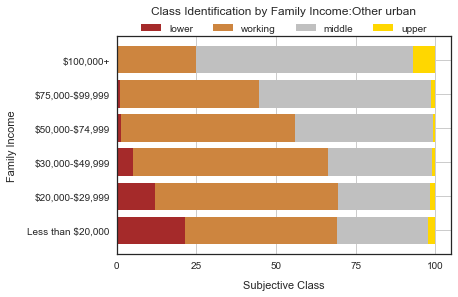

In [236]:
# Other urban
other_urban_cm = confusion_matrices[4]
x_values = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
x_pos = [i for i, _ in enumerate(x_values)]

total = other_urban_cm[0,:]+other_urban_cm[1,:]+other_urban_cm[2,:]+other_urban_cm[3,:]

prop_lower = np.true_divide(other_urban_cm[0,:], total) * 100
prop_working = np.true_divide(other_urban_cm[1,:], total) * 100
prop_middle = np.true_divide(other_urban_cm[2,:], total) * 100
prop_upper = np.true_divide(other_urban_cm[3,:], total) * 100

plt.barh(x_pos, prop_upper, height=0.8, label='upper', color='gold', 
        left=prop_middle+prop_working+prop_lower)
plt.barh(x_pos, prop_middle, height=0.8, label='middle', color='silver', 
        left=prop_working+prop_lower)
plt.barh(x_pos, prop_working, height=0.8, label='working', color='#CD853F', 
        left=prop_lower)
plt.barh(x_pos, prop_lower, height=0.8, label='lower', color='brown')

plt.yticks(x_pos, x_values)
plt.xticks([0, 25, 50, 75, 100])
plt.grid()
plt.ylabel("Family Income", labelpad=10)
plt.xlabel("Subjective Class", labelpad=10)
plt.title("Class Identification by Family Income:Other urban", pad=22)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper center", bbox_to_anchor=(0.5, 1.10),
          ncol=4)

plt.show()

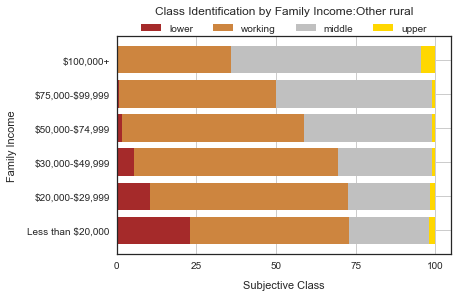

In [237]:
# Other rural
other_rural_cm = confusion_matrices[5]
x_values = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
x_pos = [i for i, _ in enumerate(x_values)]

total = other_rural_cm[0,:]+other_rural_cm[1,:]+other_rural_cm[2,:]+other_rural_cm[3,:]

prop_lower = np.true_divide(other_rural_cm[0,:], total) * 100
prop_working = np.true_divide(other_rural_cm[1,:], total) * 100
prop_middle = np.true_divide(other_rural_cm[2,:], total) * 100
prop_upper = np.true_divide(other_rural_cm[3,:], total) * 100

plt.barh(x_pos, prop_upper, height=0.8, label='upper', color='gold', 
        left=prop_middle+prop_working+prop_lower)
plt.barh(x_pos, prop_middle, height=0.8, label='middle', color='silver', 
        left=prop_working+prop_lower)
plt.barh(x_pos, prop_working, height=0.8, label='working', color='#CD853F', 
        left=prop_lower)
plt.barh(x_pos, prop_lower, height=0.8, label='lower', color='brown')

plt.yticks(x_pos, x_values)
plt.xticks([0, 25, 50, 75, 100])
plt.grid()
plt.ylabel("Family Income", labelpad=10)
plt.xlabel("Subjective Class", labelpad=10)
plt.title("Class Identification by Family Income:Other rural", pad=22)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper center", bbox_to_anchor=(0.5, 1.10),
          ncol=4)

plt.show()

Here are my observations from looking at src belt:
- 12 largest smsa (Standard Metropolitan Statistical Area) and Smsa 13-100 have similar distributions
- The working class proportions shoot up for the other rural group
- Urban groups have higher working class proportions for the highest income range compared to suburban groups. 

Next steps:
- what is the best way to visualize this data?
- should I combine the urban groups together and suburban groups together?

Resources:
- [Pew article](http://www.pewsocialtrends.org/2015/12/09/the-american-middle-class-is-losing-ground/#fnref-21084-7)
- https://www.investopedia.com/financial-edge/0912/which-income-class-are-you.aspx
- https://finance.zacks.com/lower-middle-upper-class-income-levels-9877.html
- https://en.wikipedia.org/wiki/Social_class_in_the_United_States
- https://courses.lumenlearning.com/boundless-sociology/chapter/the-class-structure-in-the-u-s/
- [Paper on Popular Conception of Class](http://ucdata.berkeley.edu/rsfcensus/papers/Hout-ClassIDJan07.pdf)
- [Census Bureau Data 2017](https://www.census.gov/library/publications/2018/demo/p60-263.html)
- [Census Bureau Data 2015](https://www.census.gov/library/publications/2016/demo/p60-256.html)
- [Census Bureau Current vs Real](https://www.census.gov/topics/income-poverty/income/guidance/current-vs-constant-dollars.html)
- [GSS Income Variables](http://gss.norc.org/Documents/reports/methodological-reports/MR064.pdf)
- ["What Is Considered Middle Class Income?"](https://www.thebalance.com/definition-of-middle-class-income-4126870)